# Tree Parse

---
## Objectives

1. Convert newick tree to PhyloXML format.
1. Fixes internal node names from an IQTREE tree. 
   - internal nodes by default get named the confidence (ex. "99/100")
   - this notebook instead gives them the name NODEi where i is an integer starting from 0.
   - NODE0 therefore becomes the root.
1. Convert tree to data frame.
1. Add metadata to PhyloXML and data frame.

---
## Setup

### Module Imports

In [1]:
import pandas as pd
from Bio import Phylo
import os
import copy
import augur
import json

# Limit how much information pandas shows when visualizing dataframe
#pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", 10)

### Input File Paths

In [2]:
tree_path = "../../docs/results/latest/iqtree/iqtree-core_chromosome.filter5.treefile"
#tree_path = "../../results/iqtree/all/iqtree-core_chromosome.filter50.treefile"
metadata_path = "../../docs/results/latest/metadata/metadata.txt"
outdir = "../../docs/results/latest/parse_tree"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

### Variables

In [3]:
# Branch Support Thresholds (from IQTREE docs)
ALRT_THRESH = 80
UFBOOT_THRESH = 95

BRANCH_LEN_SIG_DIG = 12

NAME_COL = "Sample"
NO_DATA_CHAR = "NA"

LOW_COL = "black"
HIGH_COL = "red"
TERM_COL = "grey"

# For file naming
REPO_NAME = "plague-phylogeography"
REPO_URL = "https://github.com/ktmeaton/plague-phylogeography"
AUTHOR_NAME = "Katherine Eaton"
AUTHOR_URL = "https://github.com/ktmeaton"
SCRIPT_NAME = "parse_tree"
JSON_INDENT = 2

---
## 1. Convert tree to PhyloXML format

In [4]:
tmp_xml = os.path.join(outdir, "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

## 2. Convert tree to dataframe

### Read in XML tree

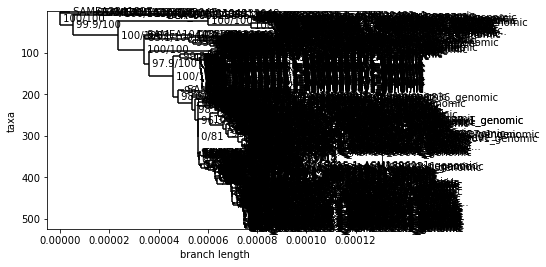

In [5]:
# Read in the new tree
tree = Phylo.read(tmp_xml, "phyloxml")

# Deepest nodes first
tree.ladderize(reverse=False)

### Fix node names and confidences

In [6]:
# Counter for integer node names
node_i = 0

# Iterate through the nodes in the tree
for c in tree.find_clades():
    # Check if the name has 'accidentally' become the confidence vals
    alrt_val = NO_DATA_CHAR
    ufboot_val = NO_DATA_CHAR    
    # If it's a named node, parse it
    if c.name:
        name_split = c.name.split("/")
        
        # Check if the name has 'accidentally' become the confidence vals
        if len(name_split) == 2:
            # Name the internal node
            c.name = "NODE" + str(node_i)    

            # Assign confidence values
            alrt_val = float(name_split[0])        
            ufboot_val = float(name_split[1])

    # If it's not a named node, give it a name
    else:
        c.name = "NODE" + str(node_i) 
    
    alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
    ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
    
    c.confidences.append(alrt_conf)
    c.confidences.append(ufboot_conf)
        
    # Increment node counter
    node_i += 1

### Initialize the tree dataframe

In [7]:
# initialize empty dataframe
tree_df = pd.DataFrame(columns = [
    "Name",
    "UFboot", 
    "aLRT", 
    "Branch_Length", 
    "Branch_Support_Color", 
    "coord_x", 
    "coord_y",]
)

for c in tree.find_clades():
    if not c.branch_length: c.branch_length = 0.0
    
    node_data = {
        "Name" : c.name,
        "UFboot" : [conf.value for conf in c.confidences if conf.type=="ufboot"][0],
        "aLRT" :  [conf.value for conf in c.confidences if conf.type=="alrt"][0],
        "Branch_Support_Color" :  NO_DATA_CHAR,
        "Branch_Length" :  c.branch_length,
        "coord_x" :  NO_DATA_CHAR,
        "coord_y" :  NO_DATA_CHAR,
    }
    
    tree_df = tree_df.append(node_data, ignore_index=True)

# Set the index to the node name
tree_df.set_index("Name", inplace=True)

# Visualize data frame
tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,100,100,0.000000e+00,NA,NA,NA
SAMEA3541827,NA,NA,3.891500e-06,NA,NA,NA
NODE2,100,81.3,1.370850e-05,NA,NA,NA
SAMEA104233046,NA,NA,2.760700e-06,NA,NA,NA
NODE4,100,100,1.114500e-06,NA,NA,NA
...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,NA,NA,NA
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,NA,NA,NA
NODE1041,100,97.9,1.172000e-06,NA,NA,NA


### Add plotting x and y coordinates of each node

In [9]:
# This code is from the biopython Phylo module

def get_x_positions(tree):
    """Create a mapping of each clade to its horizontal position.
    Dict of {clade: x-coord}
    """
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if not max(depths.values()):
        depths = tree.depths(unit_branch_lengths=True)
    return depths

def get_y_positions(tree):
    """Create a mapping of each clade to its vertical position.
    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

x_posns = get_x_positions(tree)
y_posns = get_y_positions(tree)

# Add x and y coordinates as other attributes
for c in tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Add data to tree dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,100,100,0.000000e+00,NA,0,16.9758
SAMEA3541827,NA,NA,3.891500e-06,NA,3.8915e-06,1
NODE2,100,81.3,1.370850e-05,NA,1.37085e-05,2.96875
SAMEA104233046,NA,NA,2.760700e-06,NA,1.64692e-05,2
NODE4,100,100,1.114500e-06,NA,1.4823e-05,3.9375
...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,NA,7.55257e-05,520
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,NA,7.50803e-05,521
NODE1041,100,97.9,1.172000e-06,NA,7.62055e-05,522.5


### Add branch support color

In [10]:
for c in tree.find_clades():   
    # Default Color
    branch_color = LOW_COL
    # Terminal branches will be grey
    if c.is_terminal():
        branch_color = TERM_COL
    # High support branches
    alrt_val = tree_df["aLRT"][c.name]
    ufboot_val = tree_df["UFboot"][c.name]
    if alrt_val != "NA" and ufboot_val != "NA":
        if alrt_val >= ALRT_THRESH and ufboot_val >= UFBOOT_THRESH:
            branch_color = HIGH_COL
    tree_df.at[c.name, "Branch_Support_Color"] = branch_color            

tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,100,100,0.000000e+00,red,0,16.9758
SAMEA3541827,NA,NA,3.891500e-06,grey,3.8915e-06,1
NODE2,100,81.3,1.370850e-05,red,1.37085e-05,2.96875
SAMEA104233046,NA,NA,2.760700e-06,grey,1.64692e-05,2
NODE4,100,100,1.114500e-06,red,1.4823e-05,3.9375
...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,7.55257e-05,520
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,7.50803e-05,521
NODE1041,100,97.9,1.172000e-06,red,7.62055e-05,522.5


### Parse metadata into df

In [11]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# Tell treetime which column is the taxon name
#if NAME_COL in metadata_df.columns:
#    taxon_name = NAME_COL

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)
metadata_df

,Strain,Date,DateBP,Country,Province,...,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample
Sample,,,,,,,,,,,
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,...,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,...,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,...,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,...,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922
GCA_009669625.1_ASM966962v1_genomic,42116,2005,-16,China,Xinjiang,...,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722921
...,...,...,...,...,...,...,...,...,...,...,...
IP283,IP283,1994,-27,India,Gujarat,...,71.7453,Orientalis,1.ORI,1.ORI3,IP283
IP562,IP562,1947,-74,Iran,Kurdistan,...,47.0124,Medievalis,2.MED,2.MED1,IP562
IP542,IP542,1952,-69,Kenya,NA,...,NA,Antiqua,1.ANT,1.ANT1,IP542


### Add metadata to tree and tree dataframe

In [12]:
# Iterate through the different metadata attributes
for attr in metadata_df.columns:
    # Initialize an empty column for the attribute
    tree_df[attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    # Iterate over the nodes in the tree
    for c in tree.find_clades():
        # Initialize to empty
        attr_val = NO_DATA_CHAR
        # If the node shows up in the metadata
        if c.name in metadata_df.index:
            tree_df.at[c.name, attr] = metadata_df[attr][c.name]
            attr_val = metadata_df[attr][c.name]         
        # Store the metadata as a clade attribute
        #other_meta = Phylo.PhyloXML.Other(tag=attr, value=str(attr_val), namespace="meta")   
        #c.other.append(other_meta)
tree_df

,UFboot,aLRT,Branch_Length,Branch_Support_Color,coord_x,...,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample
Name,,,,,,,,,,,
NODE0,100,100,0.000000e+00,red,0,...,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.891500e-06,grey,3.8915e-06,...,97.098,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA3541827
NODE2,100,81.3,1.370850e-05,red,1.37085e-05,...,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.760700e-06,grey,1.64692e-05,...,25.0312,Bronze Age Plague,Bronze Age,Bronze Age,SAMEA104233046
NODE4,100,100,1.114500e-06,red,1.4823e-05,...,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269265.1_ASM26926v1_genomic,NA,NA,4.688000e-07,grey,7.55257e-05,...,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141469
GCA_000269385.1_ASM26938v1_genomic,NA,NA,2.340000e-08,grey,7.50803e-05,...,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141487
NODE1041,100,97.9,1.172000e-06,red,7.62055e-05,...,NA,NA,NA,NA,NA


---
## Export

### Save tree and tree dataframe

In [13]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

out_path_xml = os.path.join(outdir,  SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tree, out_path_xml, 'phyloxml')
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

### Save lat and lon

Going to write an output tsv that is:  
resolution   name   lat    lon

In [15]:
latlon_dict = {"Country": {}, "Province": {}}
out_path_lat_lon = os.path.join(outdir, SCRIPT_NAME + "_latlon.tsv")

# Columns in data frame will be ex: CountryLat, CountryLon
for c in tree.find_clades():
    # Iterate through each geographic level
    for level in latlon_dict:
        # Store the location name
        loc = tree_df[level][c.name]
        # If the node has location data and is new
        if loc != NO_DATA_CHAR and loc not in latlon_dict[level]:
            latlon_dict[level][loc] = {}
            latlon_dict[level][loc]["lat"] = tree_df[level + "Lat"][c.name]
            latlon_dict[level][loc]["lon"] = tree_df[level + "Lon"][c.name]

with open(out_path_lat_lon, "w") as outfile:
    for level in latlon_dict:
        for loc in latlon_dict[level]:
            outfile.write(level.lower() + "\t"
                         + loc + "\t"
                         + str(latlon_dict[level][loc]["lat"]) + "\t"
                         + str(latlon_dict[level][loc]["lon"]) + "\n"
                 )

### JSON

This can then be used for auspice via:

```
augur export v2 \
  --auspice-config auspice.config \
  --tree parse_tree.nwk \
  --node-data parse_tree.json \
  --output parse_tree_auspice.json \
  --lat-longs parse_tree_latlon.tsv
```

In [14]:
# Exclude these internal variables for plotting
COLOR_KEYWORD_EXCLUDE = ["color", "coord"]

In [15]:
# There is no alignment used
node_data = {"alignment" : ""}
node_data["input_tree"] = tree_path

node_dict = {}

# Iterate through all nodes in the tree
for c in tree.find_clades():
    # Add the node to the dictionary
    node_dict[c.name] = {}
    # Iterate through all attributes in the dataframe
    for attr in tree_df.columns:
        # Check if this attribute should be excluded
        exclude = False
        for keyword in COLOR_KEYWORD_EXCLUDE:
            if keyword in attr.lower():
                exclude = True    
        if not exclude:            
            # Make attribute name in dict lowercase (ex. Branch_Length -> branch_length)
            node_dict[c.name][attr.lower()] = tree_df[attr][c.name]

        
# Add the dataframe information to the node dict for the json
node_data["nodes"] = node_dict

out_path_json = os.path.join(outdir, SCRIPT_NAME + ".json" )
augur.utils.write_json(data=node_data, file_name=out_path_json, indent=2)

---
## Cleanup

In [16]:
os.remove(tmp_xml)